# Bin Packing Lab

- Authors:
  - Luigi Quattrociocchi (quattrl@mcmaster.ca)
  - Dennis Fong (fongd1@mcmaster.ca)
- Group ID on Avenue: 42
- Gitlab URL: https://gitlab.cas.mcmaster.ca/quattrl/l2-bin-packing

## How to use the provided code?

_(this section is just here for information, you can get rid of it in your own report)_

In [1]:
from macpacking.reader import DatasetReader, BinppReader, JBurkardtReader
from macpacking.model  import Online, Offline
import macpacking.algorithms.offline as offline

Now that the business code is imported, we can load an existing dataset

In [2]:
dataset = '_datasets/binpp/N4C3W4/N4C3W4_A.BPP.txt'
# dataset = '_datasets/binpp-hard/HARD0.BPP.txt'
reader: DatasetReader = BinppReader(dataset)
print(f'Dataset: {dataset}')
print(f'  - Bin Capacity: {reader.offline()[0]}')
print(f'  - Objects to pack: {sorted(reader.offline()[1])}')

# dataset_capacity = '_datasets/jburkardt/p01_c.txt'
# dataset_weights = '_datasets/jburkardt/p01_w.txt'
# reader: DatasetReader = JBurkardtReader(dataset_capacity, dataset_weights)
# print(f'Dataset: {dataset_capacity}, {dataset_weights}')
# print(f'  - Bin Capacity: {reader.offline()[0]}')
# print(f'  - Objects to pack: {sorted(reader.offline()[1])}')

Dataset: _datasets/binpp/N4C3W4/N4C3W4_A.BPP.txt
  - Bin Capacity: 150
  - Objects to pack: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 34, 34, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 50, 50, 50, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 60, 60, 60, 60, 60, 61, 61, 61,

Acording to the `oracle.xslx` file, we now that the optimal solution for this case is to use _31_ bins. Let's call the baseline algorithm, which is an offline one, and see how it performs.

In [3]:
import macpacking.algorithms.baseline as baseline
strategy: Offline = baseline.BenMaier()
result = strategy(reader.offline())
print(result)
# print(f'{sorted(result.solution)}')

BinPackerResult(num_bins=220, wastefulness=16427.7182)


So the baseline finds the optimal solution. That's good news! Let's call our very own version of `NextFit`, as an offline algorithm.

In [4]:
import macpacking.algorithms.online as online
strategy: Offline = offline.NextFit()
result = strategy(reader.offline())
print(result)
# print(f'{sorted(result.solution)}')

BinPackerResult(num_bins=308, wastefulness=23070.0909)


Damn it, this algorithm is 4 bins far from the optimal solution! Let's try an online version. Usually, they perform worst, so let's measure it.

In [5]:
strategy: Online = online.NextFit()
result = strategy(reader.online())
print(result)
# print(f'{sorted(result.solution)}')

BinPackerResult(num_bins=287, wastefulness=21485.9861)


As expected, the online version is worst!

In [6]:
strategy: Online = online.TerribleFit()
result = strategy(reader.online())
print(result)
# print(f'{sorted(result.solution)}')

BinPackerResult(num_bins=500, wastefulness=37480.58)


In [7]:
strategy: Online = online.FirstFit()
result = strategy(reader.online())
print(result)
# print(f'{sorted(result.solution)}')

BinPackerResult(num_bins=235, wastefulness=17562.5021)


In [8]:
strategy: Online = online.BestFit()
result = strategy(reader.online())
print(result)
# print(f'{sorted(result.solution)}')

BinPackerResult(num_bins=234, wastefulness=17486.9145)


In [9]:
strategy: Online = online.WorstFit()
result = strategy(reader.online())
print(result)
# print(f'{sorted(result.solution)}')

BinPackerResult(num_bins=250, wastefulness=18695.752)


In [10]:
strategy: Offline = offline.FirstFitDecreasing()
result = strategy(reader.offline())
print(result)
# print(f'{sorted(result.solution)}')

BinPackerResult(num_bins=220, wastefulness=16427.7182)


In [11]:
strategy: Offline = offline.BestFitDecreasing()
result = strategy(reader.offline())
print(result)
# print(f'{sorted(result.solution)}')

BinPackerResult(num_bins=220, wastefulness=16427.7182)


In [12]:
strategy: Offline = offline.WorstFitDecreasing()
result = strategy(reader.offline())
print(result)
# print(f'{sorted(result.solution)}')

BinPackerResult(num_bins=220, wastefulness=16427.7182)


## Task 1

### Explanation of SOLID principles

The given code follows many design practices and implements many classic design patterns. This allows it to fulfil a couple of the SOLID principles.

**S: Single Responsibility**  
Each class has a single responsibility. For instance, the `DatasetReader` class is only responsible for transforming data from the disk into a format usable by other classes. Likewise, each concrete bin packing problem implementation has one responsibility: solving the bin packing problem.

**O: Open-closed**  
The existence of the `Online` and `Offline` abstract classes allow for extentibility in the addition of new algorithms, without requiring modifications of any existing classes. The same reasoning applies for the `DatasetReader` class.

**L: Liskov substitution**  
This is obviously satified with the `Online` and `Offline` base classes and its derived classes; the online and offline bin packing algorithms `NextFit_On`, `NextFit_Off`, and `BenMaier`, can be used as if they were their parent classes `Online` and `Offline`.

**I: Interface Segregation**  
This property is also obviously maintained. Both `BinPacker` subclasses and `DatasetReader` only provide one abstract method each, which every subclass implements. The `BinPacker` interface itself has no methods, as there is currently no shared interface between the online and offline algorithms (the process functions take different sets of parameters).

**D: Dependency Inversion**  
Similarly to the Liskov substitution principle, the abstract classes `Online` and `Offline` can be depended upon rather than their concrete subclasses. This is demonstrated in the Jupyter Notebook, in which online and offline strategies are created and used.

### Explanation of dataset dimensions
There are three important dimensions which we consider in the dataset.
- N: Number of items
- C: Bin capacity
- W: Weight (size) of each item

**Number of items**  
This number represents the total number of items we want to put into bins. This quantity is important because the time and space required to solve the bin packing problem with N items is proportional to N.

**Bin capacity**  
This number represents the capacity (maximum weight) of each bin. This quantity is important because the number of bins required in the optimal solution will be inversely proportional to the bin capacity. Some algorithms can take advantage of small capacities to come closer to an optimal solution.

**Weight of each item**  
This number represents the weight (or size) of each item. This quantity is important because the weight of each bin (relative to the bin capacity) can dictate the number of bins required in the optimal solution. Additionally, the weight of the bins can impact the optimality of certain algorithms.


## Task 2

Each column represents a single test case, read columnwise to compare algorithms on the same input.


Test Case A                                       Test Case B                                       Test Case C                                       

Case: "N4C1W1_A.BPP_NextFit_Online":              Case: "N1C3W1_A.BPP_NextFit_Online":              Case: "N1C1W4_A.BPP_NextFit_Online":              
KPI 1: Num bins     = 315                         KPI 1: Num bins     = 19                          KPI 1: Num bins     = 42                          
KPI 2: Wastefulness = 15720.2762                  KPI 2: Wastefulness = 1374.6842                   KPI 2: Wastefulness = 2073.881                    
Execution time: 0.118ms                           Execution time: 0.012ms                           Execution time: 0.015ms                           


Case: "N4C1W1_A.BPP_FirstFit_Online":             Case: "N1C3W1_A.BPP_FirstFit_Online":             Case: "N1C1W4_A.BPP_FirstFit_Online":   

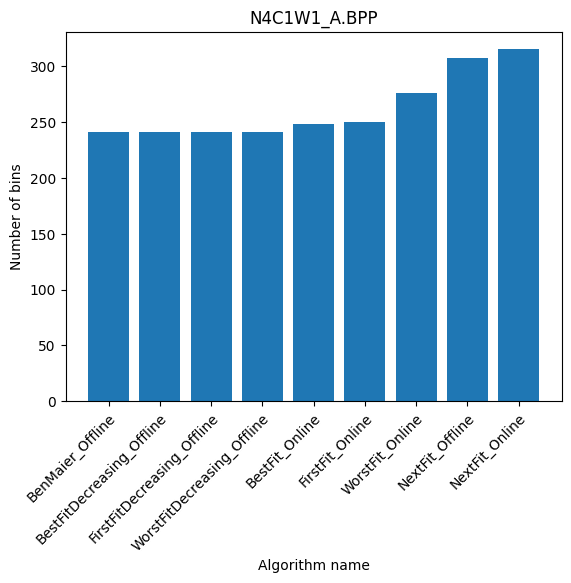

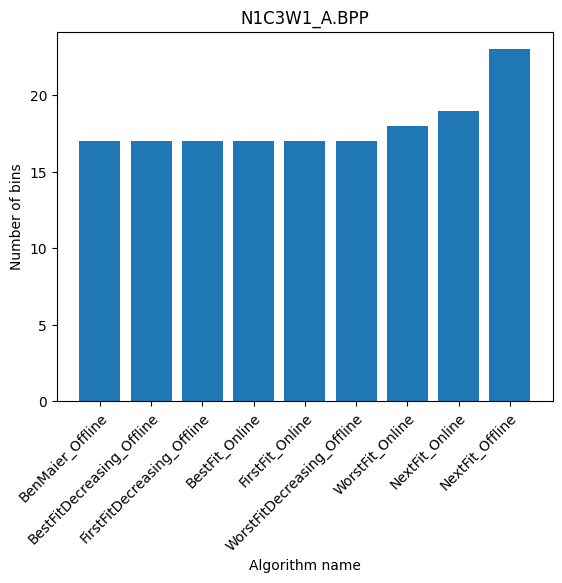

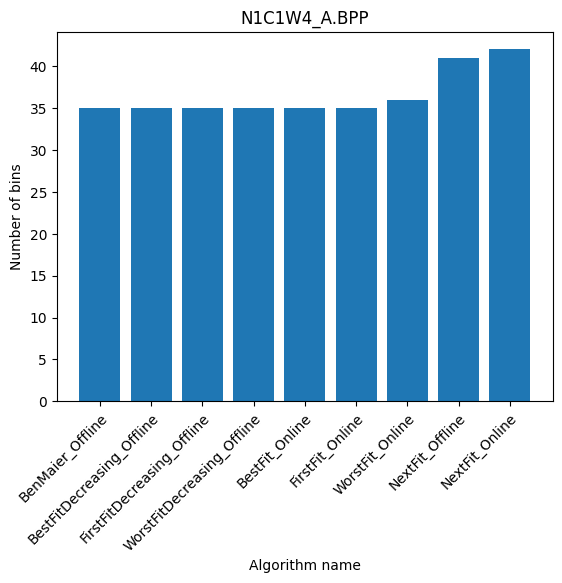

In [13]:
# Run and visualize benchmark
BENCHMARK_FILENAME = "outputs/pyperf_measurements.json"

# Run the benchmark only if a bencmkark results file outputted by pyperf does not exist
import os
if not os.path.exists(BENCHMARK_FILENAME):
    print("Running benchmark. This may take some time, go get a coffee or something...")
    !pipenv run python benchmark.py -o $BENCHMARK_FILENAME


import matplotlib.pyplot as plt
from pyperf import BenchmarkSuite
from benchmark import get_case_name, get_case_data, get_algo_name, all_cases, all_offline, all_online, make_bench_name
num_cases = len(all_cases())
benchmarks = BenchmarkSuite.load(BENCHMARK_FILENAME).get_benchmarks()
execution_times = [bench.median() for bench in benchmarks]
time_idx = 0

results = [[] for _ in range(num_cases)]
padding = 50
print("Each column represents a single test case, read columnwise to compare algorithms on the same input.\n\n")
print("".join(f"Test Case {chr(i + 65)}".ljust(padding) for i in range(num_cases)))
print(("=" * (padding * num_cases)) + "\n")
for algorithm in all_online() + all_offline():
    lines = [""]*4
    for i, case in enumerate(all_cases()):
        name = get_case_name(case)
        data = get_case_data(case)
        bench_name = make_bench_name(name, algorithm)
        result = algorithm(data)
        results[i].append((result, get_algo_name(algorithm)))
        lines[0] += f'Case: "{bench_name}":'.ljust(padding)
        lines[1] += f'KPI 1: Num bins     = {result.num_bins}'.ljust(padding)
        lines[2] += f'KPI 2: Wastefulness = {result.wastefulness}'.ljust(padding)
        lines[3] += f'Execution time: {execution_times[time_idx] * 1000:.3f}ms'.ljust(padding)
        time_idx += 1
    print("\n".join(lines))
    print("\n" + ("=" * (padding * num_cases)) + "\n")

for i, row in enumerate(results):
    row.sort()
    _, ax = plt.subplots(1, 1)
    answers, names = zip(*row)
    ax.bar(names, [a.num_bins for a in answers])
    ax.set_xticks(ax.get_xticks(), names, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(get_case_name(all_cases()[i]))
    _ = plt.ylabel("Number of bins")
    _ = plt.xlabel("Algorithm name")


## Task 3

In [14]:
from macpacking.utils import read_csv_contents

from os import listdir
from os.path import join, isdir, basename
datasets = [
    join('.', '_datasets', 'binpp'),
    join('.', '_datasets', 'binpp-hard'),
    join('.', '_datasets', 'jburkardt'),
]

case_data = {}
oracle = {}
for dataset in datasets:
    oracle_path = join(dataset, "oracle.csv")
    oracle_contents = read_csv_contents(oracle_path)
    for entry in oracle_contents:
        oracle[entry['Problem']] = entry['Optimal']


binpp_dir = datasets[0]
for folder in listdir(binpp_dir):
    folder = join(binpp_dir, folder)
    if not isdir(folder): continue
    for test_case in listdir(folder):
        test_case = join(folder, test_case)
        name = basename(test_case)[:-8]
        reader = BinppReader(test_case)
        case_data[name] = reader.offline()

binpp_hard_dir = datasets[1]
for test_case in listdir(binpp_hard_dir):
    if not test_case.startswith('HARD'):
        continue
    test_case = join(binpp_hard_dir, test_case)
    name = basename(test_case)[:-8]
    reader = BinppReader(test_case)
    case_data[name] = reader.offline()
    
import re
jburkardt_dir = datasets[2]
for test_case in listdir(jburkardt_dir):
    match = re.findall("p(\d+)_c.txt", test_case)
    if len(match) == 0: continue
    case_num = match[0]
    name = f"p_{case_num}"
    capacity_file = join(jburkardt_dir, f"p{case_num}_c.txt")
    weights_file = join(jburkardt_dir, f"p{case_num}_w.txt")
    reader = JBurkardtReader(capacity_file, weights_file)
    case_data[name] = reader.offline()

from collections import defaultdict
case_results = defaultdict(dict)
for name, data in case_data.items():
    for algorithm in all_online() + all_offline():
        result = algorithm(data)
        case_results[name][get_algo_name(algorithm)] = result

In [15]:
padding = 34
for case_name, results in case_results.items():
    print(f"{case_name}:")
    print(f"    Oracle: ".ljust(padding), oracle[case_name])
    for algo_name, result in results.items():
        print(f"    {algo_name}: ".ljust(padding), result.num_bins)

N1C1W1_A:
    Oracle:                        25
    NextFit_Online:                32
    FirstFit_Online:               26
    BestFit_Online:                26
    WorstFit_Online:               28
    NextFit_Offline:               30
    FirstFitDecreasing_Offline:    25
    BestFitDecreasing_Offline:     25
    WorstFitDecreasing_Offline:    25
    BenMaier_Offline:              25
N1C1W1_B:
    Oracle:                        31
    NextFit_Online:                36
    FirstFit_Online:               31
    BestFit_Online:                31
    WorstFit_Online:               33
    NextFit_Offline:               35
    FirstFitDecreasing_Offline:    31
    BestFitDecreasing_Offline:     31
    WorstFitDecreasing_Offline:    31
    BenMaier_Offline:              31
N1C1W1_C:
    Oracle:                        20
    NextFit_Online:                28
    FirstFit_Online:               23
    BestFit_Online:                22
    WorstFit_Online:               25
    NextFit_Offline:

## Self-reflection questions

As part of the self-reflection dimension of an experiential course, each member of the group is expected to answer to the following four questions:

  - What process did you go through to produce this result? (Backward)
  - What were your standards for this piece of work? Did you meet your standards? (Inward)
  - What the one thing you particularly want people to notice when they look at your work? (Outward)
  - What lessons will you keep from this reading/lecture in your professional practice? (Forward)